# Lite Pose

## Dataset 


Use CrowdPose to collect dataset

Dataset from: https://github.com/Jeff-sjtu/CrowdPose, which has annotations and images of CrowdPose Dataset 

dataset structure:

    -> crowdpose
        -> images 
           -> 20000 images                   
        -> json
           -> crowdpose_test.json
           -> crowdpose_train.json
           -> crowdpose_trainval.json
           -> crowdpose_val.json


## Preparation

- Install CrowdPose APIs, using https://github.com/Jeff-sjtu/CrowdPose

- Data processing: using  `lp_transform.py` to perform image augmentation  

- Target Generator: using `lp_generators.py` to generate heatmaps and joint locations for training Lite Pose model
  
- Get Data: using `lp_getDataset.py` to load images and their annotations with addtional functionality including: generating heatmaps and masks for the keypoints, applying data augmentation transformations to the images.

 - `lp_common_config.py`:  a configuration file that contains parameters that encode the model structure and the general configurations about the dataset loading, training and inference. 

In [1]:
from lp_coco_utils.lp_getDataset import getDatasetProcessed
from lp_training.lp_trainer import train
from lp_model.lp_litepose import LitePose
from lp_inference.lp_inference import inference, assocEmbedding
from lp_utils.lp_image_processing import drawHeatmap, drawKeypoints, drawSkeleton
from lp_testing.lp_evaluate import evaluateModel

import lp_config.lp_common_config as cc
import torch
import cv2

/Users/victor/Desktop/LitePose/.conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training

- Model architecture

  --> `lp_common_layers.py`: the convolutional neural network backbone with basic blocks

  ConvBlockBase: the basic building block of the network

  ConvMobileBlock: the block with mobile connectivity and residual connection function
  
  ConvStage: a sequence of ConvMobileBlocks for each stage of the backbone

  --> `lp_litepose.py`: the architecture of Lite Pose model

  backbone part: a series of convolutional stages that process the feature maps generated by the previous layer

    - convolutional block: takes the input image and applies two convolutional layers with 3x3 kernel size, followed by ReLU activation and batch normalization

    - convolutional stage: consists of a number of convolutional blocks, followed by a max-pooling layer
  
  deconvolution part: take the output of the backbone and applies a series of transposed convolutional layers to upsample the feature maps produced by the backbone

  generator part: these upsampled feature maps are fused with the feature maps from the corresponding stage in the backbone using element-wise addition and then pass these output through a series of convolutional layers to generate heatmaps for each joint

  --> `lp_model_config.py`: the configuration settings of Lite Pose model
  
  backbone part: four stages of convolutional layers
  
  deconvolution part: three transposed convolution layers
  

parameter explanation

batch_size: the number of samples that will be propagated through the network at once during training

epochs: the number of times the entire dataset will be passed through the network during training

learning_rate: the step size at which the optimizer will adjust the model weights during training

momentum: a parameter that controls the rate at which the optimizer takes into account the previous updates to the model weights

earlyStop_threshold: the number of epochs to wait before stopping the training if the validation loss does not improve

earlyStop_eps: the minimum improvement in the validation loss required to consider it as an improvement

tag_loss_weight: a weight factor to balance the impact of the tag loss during training

num_joints: the number of joints that the model is supposed to predict

max_people: the maximum number of people that the model can detect in an image.


- Model trainning

  --> parameters:

     - batch_size = 8,
     - epochs = 500,
     - learning_rate = 5e-4, 

     - momentum = 0.5,

     - earlyStop_threshold = 8,
     - earlyStop_eps = 1e-8,
     - tag_loss_weight = 0.001,

     - num_joints = 14,
     - max_people = 30

- Trainning detail

  --> `lp_loss.py`: $L = L_{MSE}+L_{aggr}+L_{push}$ 
  
    -  a mean squared error (MSE) loss for the predicted heatmaps and a tag loss for the predicted joint tags including two parts: pull part that tries to minimize the variance of the joint tags within each person, and push part that tries to maximize the distance between the joint tags of different people.
  
       -  Heatmaps Mean Squared error: the first $k$ channels are compared to the ground truth heatmaps generated during the dataset preprocessing. Hence the squared difference channel-wise, representing the estimation error, is summed up along the scale dimensions.
  
       - Tag aggregate component: it aims to reduce the variance among the tags associated to the joints that belong to a single person. To define this component, it is useful to compute the joint ($K$) tag mean for each person ($n$) as $$ \overline{h_n} = \frac{1}{K} \sum_{k}^{} h_k(x_{nk}) $$ where $h_k(x)$ is the tag value at pixel location x and $x_{nk}$ is the ground truth joint position of person $n$. Finally the loss component is calculated as $$L_{aggr}=\frac{1}{NK}\sum_{n}^{}\sum_{k}^{}(\overline{h_n}-h_k(x_{nk}))^2$$

       - Tag push component: its purpose is to maximize the difference between person tag means (to discriminate different people). This component is formalized as $$L_{push}=\frac{1}{N^2}\sum_{n}^{}\sum_{n'}^{}exp(- \frac{1}{2}(\overline{h_n} - \overline{h_{n'}})^2) $$

  --> `lp_earlyStop.py`: implement early stopping during model training to prevent overfitting

  --> `lp_trainer.py`: use the training dataset to train the model and validate model's performance on a separate validation dataset with the loss function above for each epoch
    -  choose Adam as optimizer
  
    -  implement early stopping



In [ ]:
train(cc.config["batch_size"])

## Inference

- `lp_inference.py`: using heatmap to implement the keypoint detection and connection to obtain interpretable results
  
  --> Resize the different output scales into a common scale through bilinear-interpolation in order to extract the keypoints in the right scale.  

  --> Select $n$ peaks for each joint to obtain the keypoint positions from the predicted heatmaps, here $n$ is the maximum number of people that the image may contain.

  --> Use a confidence threshold to filter the obtained keypoints.

  --> Now, the identity-free keypoints are grouped into each person by using tags. 
  
  --> Since the connection sequence is known (i.e head with neck, neck with shoulders..), exploit this knowledge and check the tags distance to connect two nodes. If they belong to adjacent joints classes, these two nodes will have an edge between them. Their tag distance is the minimum between every other pair of nodes and their tag distance is less than an additional confidence threshold.  

  --> The overall results are related to those confidence thresholds that can be tuned by considering domain dependent informations such as the image perspective and the noise.


### do test

In [2]:
from lp_testing.lp_test import test
test()

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[TEST] Dataset loading and preprocessing... [PASSED]
[TEST] Data Loader... [PASSED]
[TEST] Model loading... [PASSED]
[TEST] Model feedforward scale invariant... [PASSED]


  0%|          | 0/500 [00:01<?, ?it/s]


[TEST] Train step... [PASSED]
[TEST] Inference... [PASSED]
[TEST] 6/6 tests passed


### load model

In [3]:
model = LitePose().to(cc.config["device"])
model.load_state_dict(torch.load("lp_trained_models/model", map_location=cc.config["device"]))

<All keys matched successfully>

### load data

In [4]:
# get a preprocessed dataset for validation
ds = getDatasetProcessed("validation")

# load data
data_loader = torch.utils.data.DataLoader(
    ds,
    batch_size=8
)

row = next(iter(data_loader))
images = row[0].to(cc.config["device"])

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


### implement

In [5]:
groundTruthHeatmap = row[1]

In [6]:
output, keypoints = inference(model, images)

In [7]:
jointsHeatmap = output[1][2][:cc.config["num_joints"]]

In [17]:
img, finalHeatmap, superImposed = drawHeatmap(images[0], jointsHeatmap)
img, groundTruthFinalHeatmap, groundTruthSuperImposed = drawHeatmap(images[0], groundTruthHeatmap[1][2])

In [9]:
embedding = assocEmbedding(keypoints)

## Heatmaps

The images below show the comparison between the heatmaps ground truth and the heatmaps predicted

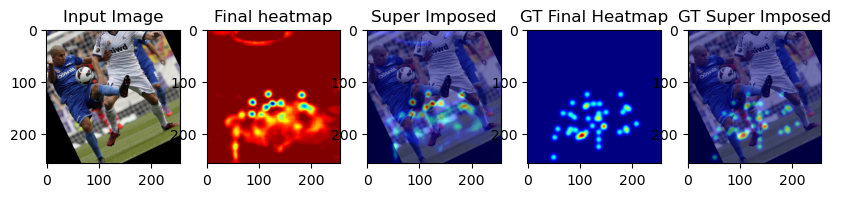

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(10,10))
axs[0].imshow(img[:,:,::-1])
axs[0].set_title('Input Image')
axs[1].imshow(finalHeatmap)
axs[1].set_title('Final heatmap')
axs[2].imshow(superImposed[:,:,::-1])
axs[2].set_title('Super Imposed')
axs[3].imshow(groundTruthFinalHeatmap[:,:,::-1])
axs[3].set_title('GT Final Heatmap')
axs[4].imshow(groundTruthSuperImposed[:,:,::-1])
axs[4].set_title('GT Super Imposed') 
plt.show()


## Keypoints

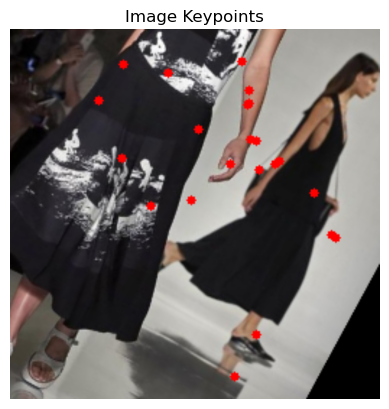

In [31]:
idx = 7
img = drawKeypoints(images[idx], keypoints[idx])
img = cv2.resize(img, (600, 600))

# Display the image using matplotlib
plt.imshow(img[:, :, ::-1])
plt.title('Image Keypoints')
plt.axis('off')
plt.show()

## Skeleton

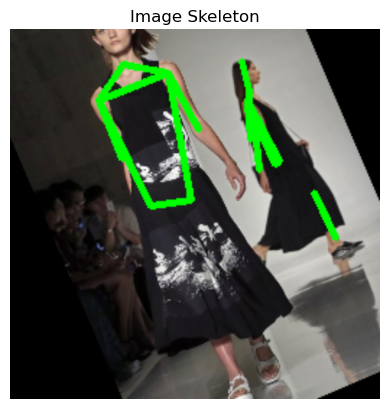

In [ ]:
import matplotlib.pyplot as plt

idx = 7
embedding = assocEmbedding(keypoints)
img = drawSkeleton(images[idx], embedding[idx])
img = cv2.resize(img, (600, 600))

# Display the image using matplotlib
plt.imshow(img[:, :, ::-1])
plt.title('Image Skeleton')
plt.axis('off')
plt.show()


## Evaluation

Object Keypoint Similarity (OKS) is wildly used performance evaluation metric for human pose estimation tasks. Despite the connection between them, OKS takes only the keypoints into account.

The metric (slightly modified) is defined as: $$ OKS = \frac{\sum_{i}^{}exp(-\frac{d_i^2}{2*k^2})*\delta(v_i>0)}{\sum_{i}^{}\delta(v_i>0)} $$
Where $d_i$ is the Euclidean distance between detected keypoints and their ground truth position, $k$ is a constant and $\delta(v_i>0)$ is a function that is 1 if the keypoint is valid, 0 otherwise

In [19]:
%pip install thop

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [21]:
from thop import profile
it = iter(data_loader)
row = next(it)
images = row[0].to(cc.config["device"])
macs, parameters = profile(model, inputs=(images,))

print(f"Model MACs: {macs}\n Model Parameters: {parameters}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
Model MACs: 97467580416.0
Model Parameters: 25008536.0


In [ ]:
res = evaluateModel(model)
print(f"Object Keypoint Similarity (OKS) score: {res*100}%")

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


100%|██████████| 250/250 [13:39<00:00,  3.28s/it]

Object Keypoint Similarity (OKS) score: 55.8199509497567%
